In [1]:
# import libraries
import pandas as pd
import rpy2.robjects as ro # allows the use of R code 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter



In [2]:
# enables the use of R code in a cell after writing "%%R making it an cell for R code 
%load_ext rpy2.ipython   

In [4]:
%%R                              
source("remove_outliers.R")      # code from predecessors
source("gather_data.R")
source("align_events.R")
source("plot_rsvi.R")
source("plot_compare.R")
source("rsvi_sites.R")
source("add_scaled_rsvi.R")
source("add_normalised_rsvi.R")

library(dplyr)
library(lubridate)
library(readr)
library(ggplot2)
library(tidyr)

# Data


The jupyther notebook should be opened in a path leading to a foder containing all the code inclusive a folder data. The code is available from [gitHub](https://github.com/martinabuck/rsvi). The data folder on gitHub is not complete but must be complemented with data from euler.ethz.ch. If access to Prof. Stockers Group is available it can be found under:

-  /cluster/home/<username>/data/modis_MOD09GA1km_fluxnet_cutouts/MOD09GA_MODOCGA_filter_indices.RData
-  /cluster/home/<username>/data/flue/flue_stocker18nphyt.csv
-  /cluster/home/<username>/data/FLUXNET-2015_Tier1/meta/fluxnet_quality_check_homogenous_OK_PRI_mbalzarolo.csv
    
Further it is partially publicly available through fLUE Stocker et al., 2018 data: https://zenodo.org/record/1158524#.W_bNMZNKjOQ. Tier1 data is publicly available and this data is retrieved from http://fluxnet.fluxdata.org/data/fluxnet2015-dataset/.

After importing the data in your data file, add your path to the data:

In [5]:
%%R
path = "/home/martina/SynologyDrive/MasterThesis/rsvi/data"
## path = "/alphadata01/bstocker/data"

### MODIS
The .RData file MOD09GA_MODOCGA_filter_indices.RData. It was assumably created by Paula Casadei with "MOD09GA_MODOCGA_filter_indices.R"  (potentially lost)
The script does the following:
1. Combines MOD09GA and MODOCGA products for all sites (one CSV for each FLUXNET site) into one.
2. Filters data by quality considering band "QC_500m" for MOD09GA (bands 1-7), band "QC_b8_15_1km" for MODOCGA (bands 11-12), and band "state_1km" for all bands (1-7, 11-12).
  - Filtering MOD09GA with bits 2 to 5 set to 0.
  - Filtering MODOCGA with bits 12 to 19 set to 0.
  - Filtering both products with bits 0, 1, 2, 8, 9, 10, 12 and 13 set to 0.
3. Creates indices as new columns for each date:
  - NDVI = (sur_refl_b02 - sur_refl_b01)/(sur_refl_b02 + sur_refl_b01))
  - EVI = 2.5 * (sur_refl_b02 * 0.0001 - sur_refl_b01 * 0.0001) / (sur_refl_b02 * 0.0001 + 6 * sur_refl_b01 * 0.0001 - 7.5 * sur_refl_b03* 0.0001 + 1))
  - NIRv = ndvi * sur_refl_b02
  - CCI = (sur_refl_b11 - sur_refl_b01)/(sur_refl_b11 + sur_refl_b01)
  - PRI = (sur_refl_b11 - sur_refl_b12)/(sur_refl_b11 + sur_refl_b12)
4. Subset data set to the following columns:

variable |description
:-------|:------------
**YY**|Year
**MM**|Month
**DD**|Day
**sites_id**| FLUXNET site ID in the format CC-SSS (CC is two-letter country code, SSS is three-character site-level identifier)
 **site_num** |  **??????????** number of observations/pixel at this site? or is this not really necessary after an site id?
    **QC_500m** | Surface Reflectance 500m Quality Assurance
    **state_1km**   | 1km Reflectance Data State QA from Terra MODIS
    **sur_refl_b01**  |Surface Reflectance for Band 1, 620 - 670 nm, Spatial Resolution 250m
    **sur_refl_b02**  |Surface Reflectance for Band 2 841 - 876 nm, Spatial Resolution 250m
    **sur_refl_b03**  |Surface Reflectance for Band 3 459 - 479 nm, Spatial Resolution 500m
    **sur_refl_b04**  |Surface Reflectance for Band 4 545 - 565 nm, Spatial Resolution 500m
    **sur_refl_b05**  |Surface Reflectance for Band 5 1230 - 1250 nm, Spatial Resolution 500m
    **sur_refl_b06**  |Surface Reflectance for Band 6 1628 - 1652 nm, Spatial Resolution 500m
    **sur_refl_b07**  |Surface Reflectance for Band 7 2105 - 2155 nm, Spatial Resolution 500m
    **QC_b8_15_1km**  |Band Quality Bands 8-15 
    **sur_refl_b11**  |Surface Reflectance for Band 11 526 - 536 nm, Spatial Resolution 1000m
    **sur_refl_b12**  |Surface Reflectance for Band 12 546 - 556 nm, Spatial Resolution 1000m
    **ndvi** | Normalized Difference Vegetation Index
    **evi** |  Enhanced Vegetation Index
    **NIRv**  | near-infrared reflectance of vegetation
    **cci** | Chlorophyll Carotenoid Index 
    **pri** |  photochemical reflectance index
    
  <span style="color:red">**Question:**</span> What is the band quality for? What is the sites_num
  
  <span style="color:red">**Possible improvement:**</span> The geoinformation/exact location of what is shown is lost. --> Rewrite this part of the code that would produce the RData file. Keep the location of the data as information for further analysis. 

Furthermore "- metainfo_sites_clusters_cGR_cDD_cLS_flue_fluxnet2015.csv
" used to see if the sites are homogeneous have coordinates. Therefore the information should be passed on as well in the data.

In [6]:
ddf = 0

In [7]:
%%R -i ddf
## uses gater_data.R and remove_outliers.R
path_modisflux = paste(path, "/modis_MOD09GA1km_fluxnet_cutouts/MOD09GA_MODOCGA_filter_indices.RData",sep="")
ddf <- gather_data(path_modisflux, add_scaled = FALSE) %>% ungroup()

[1] "Number of rows in df:   355260"
[1] "Number of rows in ddf:  355260"


gather_(path) creates the timestamp date of the format YY-MM-DD based on the RData-frame and creates a mean value for multiple entries of ndvi, evi, cci, pri, NIRv and removing outliers while doing so.




In [8]:
%%R
ddf

# A tibble: 355,260 x 7
   site   date        ndvi   evi      cci      pri  NIRv
   <chr>  <date>     <dbl> <dbl>    <dbl>    <dbl> <dbl>
 1 AR-SLu 2000-02-25 0.482 0.268  -0.128   -0.0507 1101.
 2 AR-SLu 2000-02-27 0.558 0.307  -0.0215  -0.0561 1295.
 3 AR-SLu 2000-02-28 0.542 0.241  -0.0807  -0.0593  953.
 4 AR-SLu 2000-02-29 0.543 0.325 NaN      NaN      1434.
 5 AR-SLu 2000-03-05 0.543 0.302  -0.0871  -0.0613 1256.
 6 AR-SLu 2000-03-09 0.583 0.342   0.0467  -0.0552 1468.
 7 AR-SLu 2000-03-14 0.591 0.326   0.0751  -0.0516 1400.
 8 AR-SLu 2000-03-18 0.621 0.287   0.0195  -0.0587 1188.
 9 AR-SLu 2000-03-19 0.579 0.285  -0.0369  -0.0587 1182.
10 AR-SLu 2000-03-24 0.581 0.262  -0.0395  -0.0593 1053.
# … with 355,250 more rows


### Subset homogenous sites. 

³    Selection of sites is based on whether sites could be allocated to clusters cDD, cGR, or cLS as described in [Stocker et al. (2018) *New Phytologist*]( https://doi.org/10.1111/nph.15123). And based on the selection of homogeneous by Manuela Balzarolo (see `site_selection_rsvi.Rmd`).

In [9]:
%%R
df_homo <- read_csv("./data/sites2.csv")



── Column specification ────────────────────────────────────────────────────────
cols(
  sitename = col_character(),
  cluster = col_character(),
  lon = col_double(),
  lat = col_double(),
  elv = col_double(),
  year_start = col_double(),
  year_end = col_double(),
  years_data = col_double(),
  classid = col_character(),
  whc = col_double(),
  c4 = col_logical(),
  koeppen_code = col_character(),
  kgnumber = col_double(),
  koeppen_code_extr = col_character(),
  homogenous_mbalzarolo = col_logical()
)



In [10]:
%%R
df_homo$sitename

 [1] "AR-Vir" "AU-Ade" "AU-ASM" "AU-DaP" "AU-DaS" "AU-Dry" "AU-How" "AU-Stp"
 [9] "AU-Wom" "CH-Lae" "DE-Kli" "DE-Obe" "DE-Spw" "DE-Tha" "FI-Hyy" "FR-Fon"
[17] "FR-LBr" "FR-Pue" "IT-Cpz" "IT-Ro1" "IT-SRo" "JP-SMF" "NL-Loo" "RU-Fyo"
[25] "SD-Dem" "US-Ha1" "US-MMS" "US-SRG" "US-SRM" "US-UMB" "US-UMd"


In [11]:
%%R
ddf <- ddf %>% filter( site %in% df_homo$sitename )

All the sites have now homogenous surroundings meaning that they .... Other sites are excluded from the data set. 

In [12]:
%%R
ddf

# A tibble: 65,707 x 7
   site   date        ndvi   evi     cci     pri  NIRv
   <chr>  <date>     <dbl> <dbl>   <dbl>   <dbl> <dbl>
 1 AR-Vir 2000-02-27 0.464 0.246 -0.164  -0.0501 1022.
 2 AR-Vir 2000-02-29 0.492 0.282 -0.132  -0.0565 1241.
 3 AR-Vir 2000-03-02 0.515 0.333 -0.124  -0.0569 1572.
 4 AR-Vir 2000-03-09 0.611 0.396 -0.0442 -0.0647 1898.
 5 AR-Vir 2000-03-11 0.637 0.435 -0.0242 -0.0639 2186.
 6 AR-Vir 2000-03-12 0.701 0.383  0.0165 -0.0732 1786.
 7 AR-Vir 2000-03-14 0.659 0.366 -0.0631 -0.0699 1691.
 8 AR-Vir 2000-03-18 0.618 0.412 -0.0623 -0.0642 2030.
 9 AR-Vir 2000-03-19 0.667 0.365 -0.0453 -0.0710 1676.
10 AR-Vir 2000-03-20 0.590 0.398 -0.0650 -0.0599 1958.
# … with 65,697 more rows


In [13]:
%%R
## uses add_scaled_rsvi.R 

dovars <- c("cci", "evi", "ndvi", "NIRv", "pri")
ddf <- ddf %>%
  dplyr::select(site, date, one_of(dovars)) %>%
  add_scaled_rsvi(dovars, method="range_bysite")

Based on the site and date the following information is attatched to ddf : 

- scci  
- sevi
- sndvi
- sNIRv 
- spri  
They are the normalised versions of cci, ..., pri? 

The method can be either "range_bysite" or "range". As i understood the difference is that for the normalisation the median is taken either by all the sites ("range") or by one site only ("range_bysite"). 

  <span style="color:red">**Question:**</span> is it also averaged over time?

In [15]:
%%R
ddf

# A tibble: 65,707 x 12
   site   date        scci   sevi  sndvi  sNIRv  spri     cci   evi  ndvi  NIRv
   <chr>  <date>     <dbl>  <dbl>  <dbl>  <dbl> <dbl>   <dbl> <dbl> <dbl> <dbl>
 1 AR-Vir 2000-02-27 0.151 0.0474 0.0845 0.0374 0.868 -0.164  0.246 0.464 1022.
 2 AR-Vir 2000-02-29 0.195 0.124  0.139  0.108  0.817 -0.132  0.282 0.492 1241.
 3 AR-Vir 2000-03-02 0.205 0.231  0.183  0.214  0.814 -0.124  0.333 0.515 1572.
 4 AR-Vir 2000-03-09 0.313 0.363  0.373  0.318  0.752 -0.0442 0.396 0.611 1898.
 5 AR-Vir 2000-03-11 0.340 0.445  0.424  0.411  0.758 -0.0242 0.435 0.637 2186.
 6 AR-Vir 2000-03-12 0.395 0.335  0.551  0.283  0.685  0.0165 0.383 0.701 1786.
 7 AR-Vir 2000-03-14 0.287 0.299  0.466  0.252  0.711 -0.0631 0.366 0.659 1691.
 8 AR-Vir 2000-03-18 0.288 0.396  0.387  0.361  0.756 -0.0623 0.412 0.618 2030.
 9 AR-Vir 2000-03-19 0.311 0.297  0.483  0.247  0.702 -0.0453 0.365 0.667 1676.
10 AR-Vir 2000-03-20 0.285 0.366  0.331  0.338  0.790 -0.0650 0.398 0.590 1958.
# … with 65,697 

In [16]:
%%R
ddf <- read_csv("data/flue/flue_stocker18nphyt.csv") %>% 
  select(site, date, flue, is_flue_drought) %>% 
  right_join(ddf, by=c("site", "date"))
save(ddf, file = "./data/ddf_v4.Rdata")


── Column specification ────────────────────────────────────────────────────────
cols(
  site = col_character(),
  date = col_date(format = ""),
  year = col_double(),
  doy = col_double(),
  flue = col_double(),
  is_flue_drought = col_logical(),
  cluster = col_character()
)



Now the data² following information from fLUE is added.

variable | description
:--------|:-----------------
flue  |
is_flue_drought  |

<span style="color:red">**Question:**</span> Does flue = NA automatically mean that there is a drought? Just because it is binary?

In [17]:
%%R
ddf

# A tibble: 65,707 x 14
   site   date         flue is_flue_drought  scci  sevi sndvi sNIRv  spri   cci
   <chr>  <date>      <dbl> <lgl>           <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
 1 AR-Vir 2010-02-06 NA     TRUE            0.603 0.595 0.872 0.520 0.653 0.171
 2 AR-Vir 2010-02-07  0.922 TRUE            0.595 0.925 0.760 0.901 0.733 0.165
 3 AR-Vir 2010-02-09  0.909 TRUE            0.605 0.667 0.933 0.589 0.555 0.173
 4 AR-Vir 2010-02-10  0.905 TRUE            0.607 0.896 0.852 0.859 0.560 0.174
 5 AR-Vir 2010-02-12  0.920 TRUE            0.669 0.935 0.848 0.915 0.651 0.220
 6 AR-Vir 2010-02-19 NA     TRUE            0.623 0.904 0.850 0.867 0.641 0.186
 7 AR-Vir 2010-02-25  0.963 TRUE            0.819 0.665 0.921 0.585 0.574 0.331
 8 AR-Vir 2010-02-28 NA     TRUE            0.578 0.921 0.816 0.888 0.763 0.152
 9 AR-Vir 2010-03-01  0.956 TRUE            0.640 0.590 0.921 0.515 0.590 0.198
10 AR-Vir 2010-03-02 NA     TRUE            0.615 1     0.823 0.979 0.651 0.180
# … with 65,697 

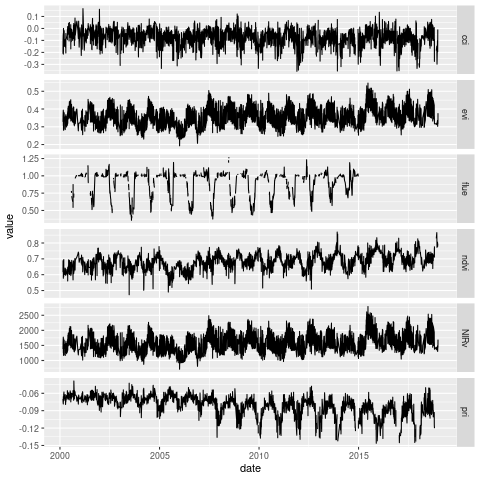

In [18]:
%%R
ddf %>% 
  tidyr::gather(rsvi, value, c(flue, ndvi, evi, cci, pri, NIRv)) %>% 
  filter(site=="FR-Pue") %>% 
  ggplot(aes(x=date, y=value)) +
  geom_line() +
  facet_grid(rows=vars(rsvi), scales = "free_y")

In [19]:
%%R
## Get fLUE Stocker et al., 2018 publicly available data here: https://zenodo.org/record/1158524#.W_bNMZNKjOQ
df_flue <- readr::read_csv( "data/flue/flue_stocker18nphyt.csv" ) %>% 
  dplyr::select(-year, -doy, -cluster) %>% 
  dplyr::rename( isevent = is_flue_drought )

## Rearrange data
out_align <- align_events( 
  ddf, 
  select(df_flue, site, date, isevent), 
  dovars, 
  leng_threshold=10, 
  before=20, after=80, nbins=10
  )
##R[write to console]: Loading required package: tidyr
##Note: Using an external vector in selections is ambiguous.
##ℹ Use `all_of(dsdovar)` instead of `dsdovar` to silence this message.
##ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
##This message is displayed once per session.



── Column specification ────────────────────────────────────────────────────────
cols(
  site = col_character(),
  date = col_date(format = ""),
  year = col_double(),
  doy = col_double(),
  flue = col_double(),
  is_flue_drought = col_logical(),
  cluster = col_character()
)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(dsdovar)` instead of `dsdovar` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


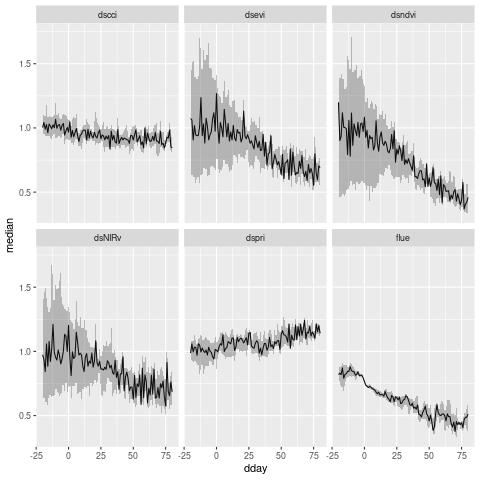

In [20]:
%%R
median <- out_align$df_dday_agg_inst %>%
  select(site, dday, ends_with("median")) %>% 
  tidyr::gather(rsvi, median, ends_with("median")) %>% 
  mutate(rsvi=stringr::str_replace(rsvi, "_median", "") )
q33 <- out_align$df_dday_agg_inst %>%
  select(site, dday, ends_with("q33")) %>% 
  tidyr::gather(rsvi, q33, ends_with("q33")) %>% 
  mutate(rsvi=stringr::str_replace(rsvi, "_q33", "") )
q66 <- out_align$df_dday_agg_inst %>%
  select(site, dday, ends_with("q66")) %>% 
  tidyr::gather(rsvi, q66, ends_with("q66")) %>% 
  mutate(rsvi=stringr::str_replace(rsvi, "_q66", "") )
df_dday_agg_inst <- median %>%
  left_join(q33, by=c("site","dday", "rsvi")) %>% 
  left_join(q66, by=c("site","dday", "rsvi"))
## Example for one site
df_dday_agg_inst %>% 
  filter(site=="US-SRM") %>% 
  filter(rsvi %in% c("flue","dsndvi", "dsevi", "dscci", "dspri", "dsNIRv")) %>% 
  ggplot(aes(x=dday, y=median)) +
  geom_line() +
  geom_ribbon(aes(ymin=q33, ymax=q66), alpha=0.3) +
  facet_wrap( ~ rsvi)

In [21]:
%%R
median <- out_align$df_dday_agg_inst_site %>%
  select(dday, ends_with("median")) %>% 
  tidyr::gather(rsvi, median, ends_with("median")) %>% 
  mutate(rsvi=stringr::str_replace(rsvi, "_median", "") )
q33 <- out_align$df_dday_agg_inst_site %>%
  select(dday, ends_with("q33")) %>% 
  tidyr::gather(rsvi, q33, ends_with("q33")) %>% 
  mutate(rsvi=stringr::str_replace(rsvi, "_q33", "") )
q66 <- out_align$df_dday_agg_inst_site %>%
  select(dday, ends_with("q66")) %>% 
  tidyr::gather(rsvi, q66, ends_with("q66")) %>% 
  mutate(rsvi=stringr::str_replace(rsvi, "_q66", "") )
df_dday_agg_inst_site <- median %>%
  left_join(q33, by=c("dday", "rsvi")) %>% 
  left_join(q66, by=c("dday", "rsvi"))


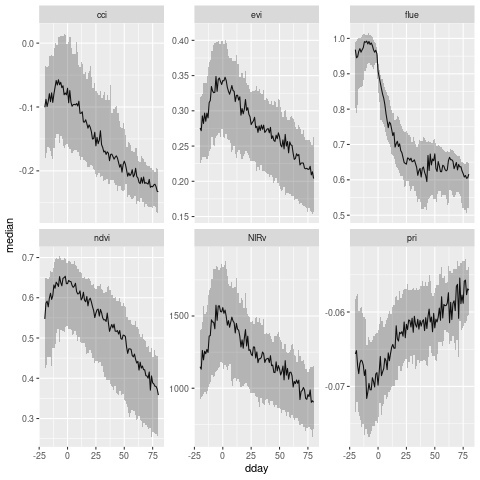

In [22]:
%%R 
df_dday_agg_inst_site %>% 
  filter(rsvi %in% c("flue","ndvi", "evi", "cci", "pri", "NIRv")) %>% 
  ggplot(aes(x=dday, y=median)) +
  geom_line() +
  geom_ribbon(aes(ymin=q33, ymax=q66), alpha=0.3) +
  facet_wrap(~rsvi, scales = "free_y")



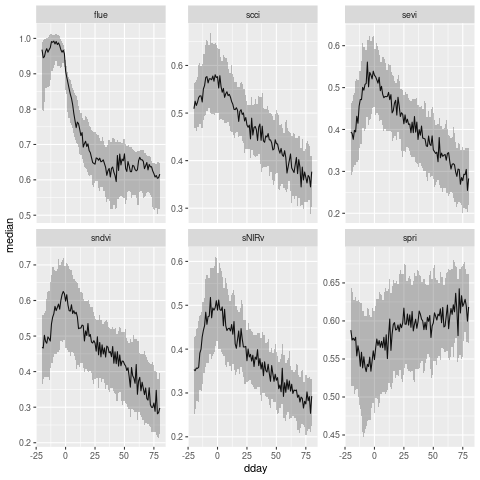

In [23]:
%%R
df_dday_agg_inst_site %>% 
  filter(rsvi %in% c("flue","sndvi", "sevi", "scci", "spri", "sNIRv")) %>% 
  ggplot(aes(x=dday, y=median)) +
  geom_line() +
  geom_ribbon(aes(ymin=q33, ymax=q66), alpha=0.3) +
  facet_wrap(~rsvi, scales = "free_y")


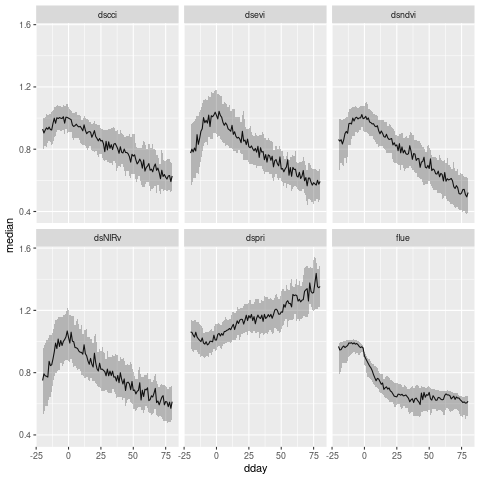

In [24]:
%%R
df_dday_agg_inst_site %>% 
  filter(rsvi %in% c("flue","dsndvi", "dsevi", "dscci", "dspri", "dsNIRv")) %>% 
  ggplot(aes(x=dday, y=median)) +
  geom_line() +
  geom_ribbon(aes(ymin=q33, ymax=q66), alpha=0.3) +
  facet_wrap(~rsvi)

If the fluxnet data changes it should be in the format of the following datasets if everything should still work as it used to for the site selection:
- metainfo_Tier1_sites_kgclimate_fluxnet2015
- metainfo_sites_clusters_cGR_cDD_cLS_flue_fluxnet2015.csv
- fluxnet_quality_check_homogenous_OK_PRI_mbalzarolo.csv

is site homogeneous?
